# Importing libraries and Dataset reading

In [ ]:
import torchvision
import torch
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import ticker
from torch.utils.data import DataLoader
from sklearn.manifold import Isomap
from torch import nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Define the transformation to apply to the dataset
transform = torchvision.transforms.transforms.Compose([
    torchvision.transforms.transforms.ToTensor(),
])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

X_train = torch.stack([X for X,_ in trainset])
y_train = [label for _,label in trainset]
X_test = torch.stack([X for X,_ in testset])
y_test = [label for _,label in testset]

100%|██████████| 26421880/26421880 [00:02<00:00, 11886768.11it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 202831.04it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3758394.67it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 2280553.13it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



# Dataset preprocessing

In [ ]:
print('dimension of each train_data: ', X_train.shape)
print('dimension of each test_data: ', X_test.shape)
flatten_X_train = X_train.reshape(60000, 784)
flatten_X_test = X_test.reshape(10000, 784)
print('dimension of each flatten_train_data: ', flatten_X_train.shape)
print('dimension of each flatten_test_data: ', flatten_X_test.shape)

dimension of each train_data:  torch.Size([60000, 1, 28, 28])
dimension of each test_data:  torch.Size([10000, 1, 28, 28])
dimension of each flatten_train_data:  torch.Size([60000, 784])
dimension of each flatten_test_data:  torch.Size([10000, 784])


# PCA

In [ ]:
pipeline = Pipeline([
    ('pca', PCA()),
    ('knn', KNeighborsClassifier())
])
components_number_ceil = np.ceil(0.05 * 784)
components_number_floor = 0.03 * 784
dimensions_reduction_params = np.arange(int(components_number_floor), int(components_number_ceil))
knn_params = [int(i) for i in (np.arange(1,int((len(X_train) ** 0.5)), (len(X_train) ** 0.5)/60))]
parameters = {
  'pca__n_components': dimensions_reduction_params,
  'knn__n_neighbors': knn_params
}
random_search = RandomizedSearchCV(pipeline, parameters, cv=5, scoring='accuracy')
random_search.fit(flatten_X_train, y_train)
best_performance = random_search.best_score_
print("Best Number of Components:", random_search.best_params_)
print("Best Performance:", "{:.4f}".format(random_search.best_score_))
best_estimator = random_search.best_estimator_
pca = best_estimator.named_steps['pca']
knn = best_estimator.named_steps['knn']
X_test_after_pca = pca.transform(flatten_X_test)
knn_X_test_result = knn.predict(X_test_after_pca)
print("Accuracy for test set: ", "{:.4f}".format(accuracy_score(y_test, knn_X_test_result)))

Best Number of Components: {'pca__n_components': 24, 'knn__n_neighbors': 9}
Best Performance: 0.8506
Accuracy for test set:  0.8479


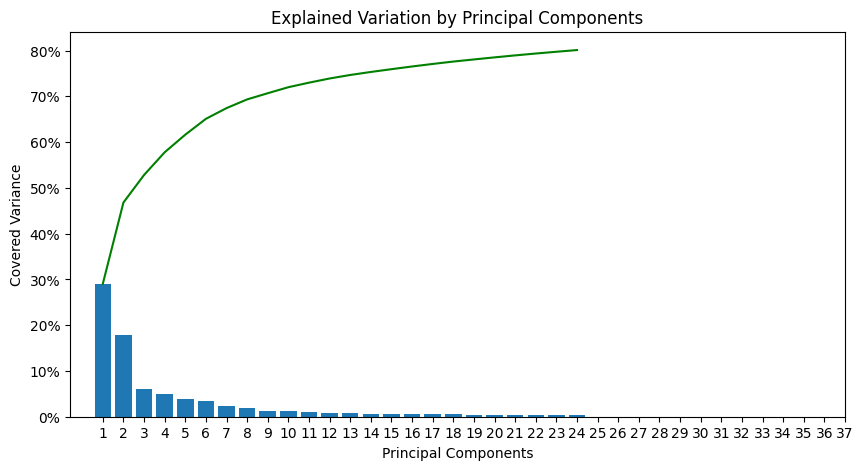

In [ ]:
x_range = np.array(range(1,random_search.best_params_['pca__n_components']+1))
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.plot(x_range, pca.explained_variance_ratio_.cumsum(), color='green')
ax.bar(x_range, pca.explained_variance_ratio_)
ax.set_xlabel('Principal Components')
ax.set_ylabel('Covered Variance')
ax.set_title('Explained Variation by Principal Components')
ax.set_xticks(np.arange(1, 37+1), [str(i) for i in range(1, 37+1)])
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

# ISOMAP

In [ ]:
pipeline = Pipeline([
    ('isomap', Isomap()),
    ('knn', KNeighborsClassifier())
])
parameters = {
  'isomap__n_components': dimensions_reduction_params,
  'knn__n_neighbors': knn_params
}

random_search = RandomizedSearchCV(pipeline, parameters, cv=5, scoring='accuracy')
random_search.fit(flatten_X_train[0:2000], y_train[0:2000])

best_performance = random_search.best_score_

print("Best Number of Components:", random_search.best_params_)
print("Best Performance:", random_search.best_score_)

best_estimator = random_search.best_estimator_
isomap = best_estimator.named_steps['isomap']
knn = best_estimator.named_steps['knn']
X_test_after_isomap = isomap.transform(flatten_X_test)
knn_X_test_result = knn.predict(X_test_after_isomap)
print("Accuracy for test set: ", accuracy_score(y_test, knn_X_test_result))

Best Number of Components: {'knn__n_neighbors': 5, 'isomap__n_components': 35}
Best Performance: 0.75
Accuracy for test set:  0.7458


In [ ]:
class CustomCNNAutoEncoder(torch.nn.Module):
  def __init__(self, latent_space):
    super().__init__()
    # Encoder layers
    self.encoder = torch.nn.Sequential(
      torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
      torch.nn.BatchNorm2d(16),
      torch.nn.ReLU(True),
      torch.nn.MaxPool2d(kernel_size=2, stride=2),
      torch.nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
      torch.nn.BatchNorm2d(8),
      torch.nn.ReLU(True),
      torch.nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.flatten = torch.nn.Flatten()
    self.to_latent = torch.nn.Linear(7*7*8, latent_space)
    self.to_decoder = torch.nn.Linear(latent_space, 7*7*8)
    self.decoder = torch.nn.Sequential(
      torch.nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
      torch.nn.BatchNorm2d(16),
      torch.nn.ReLU(True),
      torch.nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
      torch.nn.Sigmoid()
    )


  def forward(self, x, encoder_output = False):
    e = self.encoder(x)

    e = self.flatten(e)
    e = self.to_latent(e)
    if encoder_output:
      return e

    e = self.to_decoder(e)
    e = e.reshape((x.shape[0],8,7,7))
    d = self.decoder(e)
    return d




class CustomLinearAutoEncoder(torch.nn.Module):
  def __init__(self, latent_space):
    super().__init__()
    primary_space = 784
    self.encoder = torch.nn.Sequential(
      torch.nn.Linear(primary_space, primary_space//2),
      torch.nn.BatchNorm1d(primary_space//2),
      torch.nn.ReLU(True),
      torch.nn.Linear(primary_space//2, primary_space//4),
      torch.nn.BatchNorm1d(primary_space//4),
      torch.nn.ReLU(True),
      torch.nn.Linear(primary_space//4, primary_space//8),
      torch.nn.BatchNorm1d(primary_space//8),
      torch.nn.ReLU(True),
      torch.nn.Linear(primary_space//8, primary_space//16),
      torch.nn.BatchNorm1d(primary_space//16),
      torch.nn.ReLU(True),
      torch.nn.Linear(primary_space//16, latent_space)
    )
    self.decoder = torch.nn.Sequential(
      torch.nn.Linear(latent_space, primary_space//16),
      torch.nn.BatchNorm1d(primary_space//16),
      torch.nn.ReLU(True),
      torch.nn.Linear(primary_space//16, primary_space//8),
      torch.nn.BatchNorm1d(primary_space//8),
      torch.nn.ReLU(True),
      torch.nn.Linear(primary_space//8, primary_space//4),
      torch.nn.BatchNorm1d(primary_space//4),
      torch.nn.ReLU(True),
      torch.nn.Linear(primary_space//4, primary_space//2),
      torch.nn.BatchNorm1d(primary_space//2),
      torch.nn.ReLU(True),
      torch.nn.Linear(primary_space//2, primary_space),
      torch.nn.Sigmoid()
    )
  def forward(self, x, encoder_output = False):
    x = x.reshape((x.shape[0], 28*28))

    e = self.encoder(x)
    if encoder_output:
      return e

    d = self.decoder(e)
    return d

model_linear_1 = CustomLinearAutoEncoder(latent_space=40)
model_linear_2 = CustomLinearAutoEncoder(latent_space=7)
model_CNN_1 = CustomCNNAutoEncoder(latent_space=40)
model_CNN_2 = CustomCNNAutoEncoder(latent_space=7)

In [ ]:
def train_ae(X_train, model, epochs = 10, batch_size = 100):
  X_loader = DataLoader(X_train, batch_size= batch_size)
  model = model.to(device)
  optimizer = torch.optim.AdamW(model.parameters())
  loss_fn = torch.nn.MSELoss()

  for e in range(epochs):
    model.train()
    training_loss = 0
    for inputs in X_loader:
      inputs = inputs.to(device)
      output = model(inputs)
      inputs = inputs.reshape((batch_size, 784))
      output = output.reshape((batch_size, 784))
      loss = loss_fn(output, inputs)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      training_loss += loss.item()
    training_loss = training_loss / len(X_loader)
    print(f"Epoch [{e + 1}/{epochs}], Loss: {training_loss:.4f}")
  return None

def knn_param_random_search(X_train, y_train, X_test, y_test):
  pipeline = Pipeline([
      ('knn', KNeighborsClassifier())
  ])
  knn_params = [int(i) for i in (np.arange(1,int((len(X_train) ** 0.5)), (len(X_train) ** 0.5)/60))]
  parameters = {
    'knn__n_neighbors': knn_params
  }

  random_search = RandomizedSearchCV(pipeline, parameters, cv=5, scoring='accuracy')
  random_search.fit(X_train, y_train)

  best_performance = random_search.best_score_

  print("Best Number of Components:", random_search.best_params_)
  print("Best Performance:", random_search.best_score_)

  best_estimator = random_search.best_estimator_
  knn = best_estimator.named_steps['knn']
  knn_X_test_result = knn.predict(X_test)
  print("Accuracy for test set: ", accuracy_score(y_test, knn_X_test_result))

### Auto-encoder with Linear layers and 40 layers at latent space (95% dimensions reduction)

In [ ]:
model_linear_1_loss_history = train_ae(X_train, model_linear_1)

Epoch [1/10], Loss: 0.0255
Epoch [2/10], Loss: 0.0177
Epoch [3/10], Loss: 0.0160
Epoch [4/10], Loss: 0.0149
Epoch [5/10], Loss: 0.0142
Epoch [6/10], Loss: 0.0137
Epoch [7/10], Loss: 0.0133
Epoch [8/10], Loss: 0.0129
Epoch [9/10], Loss: 0.0126
Epoch [10/10], Loss: 0.0124


In [ ]:
model_linear_1.eval()
with torch.no_grad():
  X_test_after_ae = (model_linear_1(X_test.to(device), True)).cpu()
  X_train_after_ae = (model_linear_1(X_train.to(device), True)).cpu()

knn_param_random_search(X_train_after_ae, y_train, X_test_after_ae, y_test)

Best Number of Components: {'knn__n_neighbors': 13}
Best Performance: 0.8615
Accuracy for test set:  0.8599


### Auto-encoder with Linear layers and 7 layers at latent space (99% dimensions reduction)

In [ ]:
model_linear_2_loss_history = train_ae(X_train, model_linear_2)

Epoch [1/10], Loss: 0.0266
Epoch [2/10], Loss: 0.0193
Epoch [3/10], Loss: 0.0177
Epoch [4/10], Loss: 0.0168
Epoch [5/10], Loss: 0.0163
Epoch [6/10], Loss: 0.0159
Epoch [7/10], Loss: 0.0156
Epoch [8/10], Loss: 0.0154
Epoch [9/10], Loss: 0.0152
Epoch [10/10], Loss: 0.0150


In [ ]:
model_linear_2.eval()
with torch.no_grad():
  X_test_after_ae = (model_linear_2(X_test.to(device), True)).cpu()
  X_train_after_ae = (model_linear_2(X_train.to(device), True)).cpu()


knn_param_random_search(X_train_after_ae, y_train, X_test_after_ae, y_test)

Best Number of Components: {'knn__n_neighbors': 45}
Best Performance: 0.8372166666666667
Accuracy for test set:  0.8299


### Auto-encoder with Conv layers and 40 layers at latent space (95% dimensions reduction)

In [ ]:
model_CNN_1_loss_history = train_ae(X_train, model_CNN_1)

Epoch [1/10], Loss: 0.0272
Epoch [2/10], Loss: 0.0129
Epoch [3/10], Loss: 0.0115
Epoch [4/10], Loss: 0.0108
Epoch [5/10], Loss: 0.0103
Epoch [6/10], Loss: 0.0100
Epoch [7/10], Loss: 0.0098
Epoch [8/10], Loss: 0.0096
Epoch [9/10], Loss: 0.0094
Epoch [10/10], Loss: 0.0093


In [ ]:
model_CNN_1.eval()
with torch.no_grad():
  X_test_after_ae = (model_CNN_1(X_test.to(device), True)).cpu()
  X_train_after_ae = (model_CNN_1(X_train.to(device), True)).cpu()

knn_param_random_search(X_train_after_ae, y_train, X_test_after_ae, y_test)

Best Number of Components: {'knn__n_neighbors': 9}
Best Performance: 0.8697833333333334
Accuracy for test set:  0.8679


### Auto-encoder with Conv layers and 7 layers at latent space (99% dimensions reduction)

In [ ]:
model_CNN_2_loss_history = train_ae(X_train, model_CNN_2)

Epoch [1/10], Loss: 0.0448
Epoch [2/10], Loss: 0.0246
Epoch [3/10], Loss: 0.0229
Epoch [4/10], Loss: 0.0218
Epoch [5/10], Loss: 0.0211
Epoch [6/10], Loss: 0.0206
Epoch [7/10], Loss: 0.0203
Epoch [8/10], Loss: 0.0200
Epoch [9/10], Loss: 0.0198
Epoch [10/10], Loss: 0.0196


In [ ]:
model_CNN_2.eval()
with torch.no_grad():
  X_test_after_ae = (model_CNN_2(X_test.to(device), True)).cpu()
  X_train_after_ae = (model_CNN_2(X_train.to(device), True)).cpu()

knn_param_random_search(X_train_after_ae, y_train, X_test_after_ae, y_test)

Best Number of Components: {'knn__n_neighbors': 29}
Best Performance: 0.8116333333333333
Accuracy for test set:  0.8082


# VAE

In [ ]:
class LinearVAE(nn.Module):
  def __init__(self, latent_space):
    super(LinearVAE, self).__init__()
    primary_space = 784
    self.encoder = torch.nn.Sequential(
      torch.nn.Linear(primary_space, primary_space//2),
      torch.nn.BatchNorm1d(primary_space//2),
      torch.nn.ReLU(True),
      torch.nn.Linear(primary_space//2, primary_space//4),
      torch.nn.BatchNorm1d(primary_space//4),
      torch.nn.ReLU(True),
      torch.nn.Linear(primary_space//4, primary_space//8),
      torch.nn.BatchNorm1d(primary_space//8),
      torch.nn.ReLU(True),
      torch.nn.Linear(primary_space//8, primary_space//16),
      torch.nn.BatchNorm1d(primary_space//16),
      torch.nn.ReLU(True),
    )
    self.mu = nn.Linear(primary_space//16, latent_space)
    self.logvar = nn.Linear(primary_space//16, latent_space)
    self.decoder = torch.nn.Sequential(
      torch.nn.Linear(latent_space, primary_space//16),
      torch.nn.BatchNorm1d(primary_space//16),
      torch.nn.ReLU(True),
      torch.nn.Linear(primary_space//16, primary_space//8),
      torch.nn.BatchNorm1d(primary_space//8),
      torch.nn.ReLU(True),
      torch.nn.Linear(primary_space//8, primary_space//4),
      torch.nn.BatchNorm1d(primary_space//4),
      torch.nn.ReLU(True),
      torch.nn.Linear(primary_space//4, primary_space//2),
      torch.nn.BatchNorm1d(primary_space//2),
      torch.nn.ReLU(True),
      torch.nn.Linear(primary_space//2, primary_space),
      torch.nn.Sigmoid()
    )
  def encode(self, x):
    e = self.encoder(x)
    mu = self.mu(e)
    logvar = self.logvar(e)
    return mu, logvar, e

  def decode(self, z):
    x = self.decoder(z)
    return x

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    z = mu + eps * std
    return z
  def forward(self, x, disable_decoder = False):
    x = x.reshape((x.shape[0], 28*28))
    mu, logvar, e = self.encode(x)
    z = self.reparameterize(mu, logvar)
    if disable_decoder:
      return z, mu, logvar
    new_x = self.decode(z)
    return new_x, mu, logvar




class CnnVAE(nn.Module):
  def __init__(self, latent_space):
    super(CnnVAE, self).__init__()
    primary_space = 784
    self.encoder = torch.nn.Sequential(
      torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
      torch.nn.BatchNorm2d(16),
      torch.nn.ReLU(True),
      torch.nn.MaxPool2d(kernel_size=2, stride=2),
      torch.nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
      torch.nn.BatchNorm2d(8),
      torch.nn.ReLU(True),
      torch.nn.MaxPool2d(kernel_size=2, stride=2),
      torch.nn.Flatten()
    )


    self.mu = nn.Linear(7*7*8, latent_space)
    self.logvar = nn.Linear(7*7*8, latent_space)
    self.to_decoder = torch.nn.Linear(latent_space, 7*7*8)
    self.decoder = torch.nn.Sequential(
      torch.nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
      torch.nn.BatchNorm2d(16),
      torch.nn.ReLU(True),
      torch.nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
      torch.nn.Sigmoid()
    )
  def encode(self, x):
    e = self.encoder(x)
    mu = self.mu(e)
    logvar = self.logvar(e)
    return mu, logvar, e

  def decode(self, z):
    x = self.decoder(z)
    return x

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    z = mu + eps * std
    return z
  def forward(self, x, disable_decoder = False):
    mu, logvar, e = self.encode(x)
    z = self.reparameterize(mu, logvar)
    if disable_decoder:
      return z, mu, logvar
    z = self.to_decoder(z)
    z = z.reshape((x.shape[0],8,7,7))
    new_x = self.decode(z)
    return new_x, mu, logvar


model_linear_1 = LinearVAE(latent_space=40)
model_linear_2 = LinearVAE(latent_space=7)
model_CNN_1 = CnnVAE(latent_space=40)
model_CNN_2 = CnnVAE(latent_space=7)

In [ ]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.BCELoss(reduction='sum')(recon_x.reshape((recon_x.shape[0], 28*28)), x.reshape((x.shape[0], 28*28)))
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

def train_vae(X_train, model, epochs = 10, batch_size = 100, latent_dim = 40):
  latent_dim = 40
  X_loader = DataLoader(X_train, batch_size= batch_size)
  model = model.to(device)
  optimizer = torch.optim.AdamW(model.parameters())
  training_loss_history = []
  for e in range(epochs):
    model.train()
    training_loss = 0
    for data in X_loader:
      data = data.to(device)
      recon_batch, mu, logvar = model(data)
      loss = vae_loss(recon_batch, data, mu, logvar)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      training_loss += loss.item()
    training_loss /= len(X_loader)
    print(f"Epoch [{e + 1}/{epochs}], Loss: {training_loss:.4f}")
    training_loss_history.append(training_loss)
    model.eval()
  return training_loss_history

def knn_param_random_search(X_train, y_train, X_test, y_test):
  pipeline = Pipeline([
      ('knn', KNeighborsClassifier())
  ])
  knn_params = [int(i) for i in (np.arange(1,int((len(X_train) ** 0.5)), (len(X_train) ** 0.5)/60))] ##gofte maghale
  parameters = {
    'knn__n_neighbors': knn_params
  }

  random_search = RandomizedSearchCV(pipeline, parameters, cv=5, scoring='accuracy')#default steps_number = 10
  random_search.fit(X_train, y_train)

  best_performance = random_search.best_score_

  print("Best Number of Components:", random_search.best_params_)
  print("Best Performance:", random_search.best_score_)

  best_estimator = random_search.best_estimator_
  knn = best_estimator.named_steps['knn']
  knn_X_test_result = knn.predict(X_test)
  print("Accuracy for test set: ", accuracy_score(y_test, knn_X_test_result))

### VAE with Linear layers and 40 layer at latent space (95% dimensions reduction)

In [ ]:
model_linear_1_loss_history = train_vae(X_train, model_linear_1)
model_linear_1.eval()
with torch.no_grad():
  X_test_after_ae = (model_linear_1(X_test.to(device), True))[0].cpu()
  X_train_after_ae = (model_linear_1(X_train.to(device), True))[0].cpu()

knn_param_random_search(X_train_after_ae, y_train, X_test_after_ae, y_test)

Epoch [1/10], Loss: 28687.0183
Epoch [2/10], Loss: 26032.1010
Epoch [3/10], Loss: 25250.4708
Epoch [4/10], Loss: 24908.6129
Epoch [5/10], Loss: 24732.5512
Epoch [6/10], Loss: 24613.6410
Epoch [7/10], Loss: 24522.9978
Epoch [8/10], Loss: 24462.6173
Epoch [9/10], Loss: 24400.0368
Epoch [10/10], Loss: 24353.4886
Best Number of Components: {'knn__n_neighbors': 213}
Best Performance: 0.6795833333333334
Accuracy for test set:  0.6735


### VAE with Linear layers and 7 layer at latent space (99% dimensions reduction)

In [ ]:
model_linear_2_loss_history = train_vae(X_train, model_linear_2.to(device))

Epoch [1/10], Loss: 27706.0200
Epoch [2/10], Loss: 25442.5777
Epoch [3/10], Loss: 25057.2624
Epoch [4/10], Loss: 24855.0972
Epoch [5/10], Loss: 24722.1294
Epoch [6/10], Loss: 24639.4614
Epoch [7/10], Loss: 24559.3320
Epoch [8/10], Loss: 24508.6471
Epoch [9/10], Loss: 24452.9567
Epoch [10/10], Loss: 24413.5916


In [ ]:
model_linear_2.eval()
with torch.no_grad():
  X_test_after_ae = (model_linear_2(X_test.to(device), True))[0].cpu()
  X_train_after_ae = (model_linear_2(X_train.to(device), True))[0].cpu()

knn_param_random_search(X_train_after_ae, y_train, X_test_after_ae, y_test)

Best Number of Components: {'knn__n_neighbors': 74}
Best Performance: 0.7921333333333334
Accuracy for test set:  0.7893


### VAE with Conv layers and 40 layer at latent space (95% dimensions reduction)

In [ ]:
model_CNN_1_loss_history = train_vae(X_train, model_CNN_1.to(device))

Epoch [1/10], Loss: 30392.9232
Epoch [2/10], Loss: 26013.9174
Epoch [3/10], Loss: 25581.9561
Epoch [4/10], Loss: 25378.6407
Epoch [5/10], Loss: 25238.6678
Epoch [6/10], Loss: 25138.7537
Epoch [7/10], Loss: 25053.4504
Epoch [8/10], Loss: 24986.9586
Epoch [9/10], Loss: 24940.2355
Epoch [10/10], Loss: 24897.8043


In [ ]:
model_CNN_1.eval()
with torch.no_grad():
  X_test_after_ae = (model_CNN_1(X_test.to(device), True))[0].cpu()
  X_train_after_ae = (model_CNN_1(X_train.to(device), True))[0].cpu()

knn_param_random_search(X_train_after_ae, y_train, X_test_after_ae, y_test)

Best Number of Components: {'knn__n_neighbors': 62}
Best Performance: 0.7645500000000001
Accuracy for test set:  0.7585


### VAE with Conv layers and 7 layer at latent space (99% dimensions reduction)

In [ ]:
model_CNN_2_loss_history = train_vae(X_train, model_CNN_2.to(device))

Epoch [1/10], Loss: 30472.0305
Epoch [2/10], Loss: 26182.1270
Epoch [3/10], Loss: 25781.2290
Epoch [4/10], Loss: 25603.0461
Epoch [5/10], Loss: 25489.6029
Epoch [6/10], Loss: 25403.5651
Epoch [7/10], Loss: 25340.7872
Epoch [8/10], Loss: 25289.5749
Epoch [9/10], Loss: 25245.3905
Epoch [10/10], Loss: 25213.2166


In [ ]:
model_CNN_2.eval()
with torch.no_grad():
  X_test_after_ae = (model_CNN_2(X_test.to(device), True))[0].cpu()
  X_train_after_ae = (model_CNN_2(X_train.to(device), True))[0].cpu()

knn_param_random_search(X_train_after_ae, y_train, X_test_after_ae, y_test)

Best Number of Components: {'knn__n_neighbors': 21}
Best Performance: 0.7959833333333333
Accuracy for test set:  0.7861


# Exploration in Latent Space

In [ ]:
def plot_latent_space(model = None, n=10, figsize=6, arch = 'cnn'):
    image_size = 28
    scale = 2.0
    figure = np.zeros((image_size * n, image_size * n))
    grid_x = torch.linspace(-2, 2, 10)
    grid_y = torch.flip(torch.linspace(-2, 2, 10),(0,))
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            x_decoded = norm_to_img(model, torch.tensor([xi, yi]), arch).cpu().detach().numpy()
            image = x_decoded[0].reshape(image_size, image_size)
            figure[
                i * image_size : (i + 1) * image_size,
                j * image_size : (j + 1) * image_size,
            ] = image

    plt.figure(figsize=(figsize, figsize))
    start_range = image_size // 2
    end_range = n * image_size + start_range
    pixel_range = np.arange(start_range, end_range, image_size)
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

def plot_label_clusters(model, data, labels, param = 'z'):
  data = data.to(device)
  if param == 'z':
    z_mean,_, _ = model(data, True)
  elif param == 'mean':
    _, z_mean, _ = model(data, True)
  else:
    _, _, z_mean = model(data, True)
  z_mean = z_mean.cpu().detach().numpy()
  plt.figure(figsize=(8, 6))
  scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, cmap='Spectral', alpha=0.5)
  num_labels = len(np.unique(labels))
  cb = plt.colorbar(scatter)
  fashion_mnist_labels = ['T-shirt/top', 'Trouser', 'Pullover',
                          'Dress', 'Coat', 'Sandal', 'Shirt',
                          'Sneaker', 'Bag', 'Ankle boot']
  cb.set_ticks(np.arange(num_labels))
  cb.set_ticklabels(fashion_mnist_labels)
  plt.xlabel("z[0]")
  plt.ylabel("z[1]")
  plt.show();

def norm_to_img(model, z, arch = 'cnn'):
  z = z.to(device)
  if arch == 'cnn':
    z = model.to_decoder(z)
    z = z.reshape((1,8,7,7))
  else:
    z=z.reshape((1,2))
  new_x = model.decode(z)
  return new_x

In [ ]:
investigating_model = LinearVAE(2).to(device)
investigating_model_loss = train_vae(X_train, investigating_model)

Epoch [1/10], Loss: 28219.3198
Epoch [2/10], Loss: 26530.6756
Epoch [3/10], Loss: 26304.2897
Epoch [4/10], Loss: 26134.4688
Epoch [5/10], Loss: 26112.2855
Epoch [6/10], Loss: 25949.0773
Epoch [7/10], Loss: 25906.0630
Epoch [8/10], Loss: 25845.3576
Epoch [9/10], Loss: 25783.6907
Epoch [10/10], Loss: 25793.8536


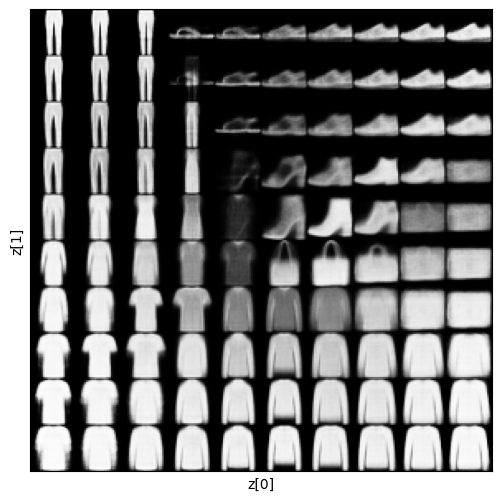

In [ ]:
plot_latent_space(investigating_model,arch = 'linear')

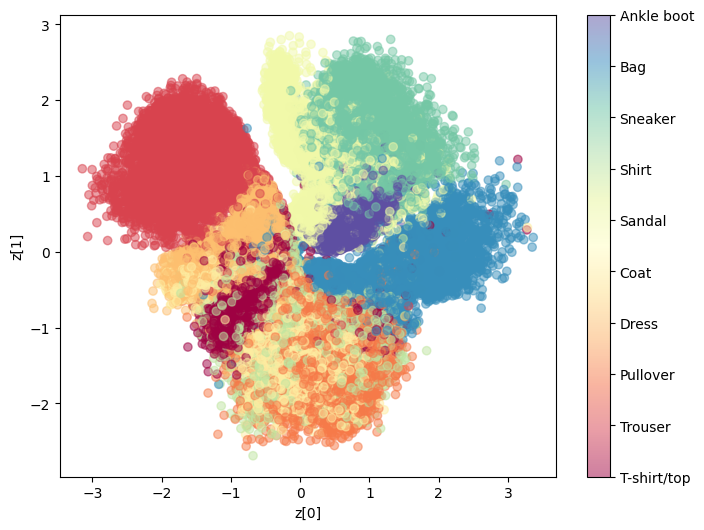

In [ ]:
plot_label_clusters(investigating_model, X_train ,y_train)

In [ ]:
investigating_model = CnnVAE(2).to(device)
investigating_model_loss = train_vae(X_train, investigating_model)

Epoch [1/10], Loss: 34559.0185
Epoch [2/10], Loss: 29128.4765
Epoch [3/10], Loss: 28516.9926
Epoch [4/10], Loss: 28282.6861
Epoch [5/10], Loss: 28142.9697
Epoch [6/10], Loss: 28038.3021
Epoch [7/10], Loss: 27951.4569
Epoch [8/10], Loss: 27881.0648
Epoch [9/10], Loss: 27827.0539
Epoch [10/10], Loss: 27781.6502


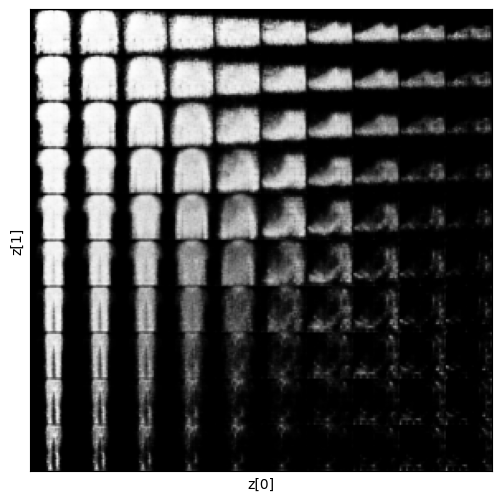

In [ ]:
plot_latent_space(investigating_model)

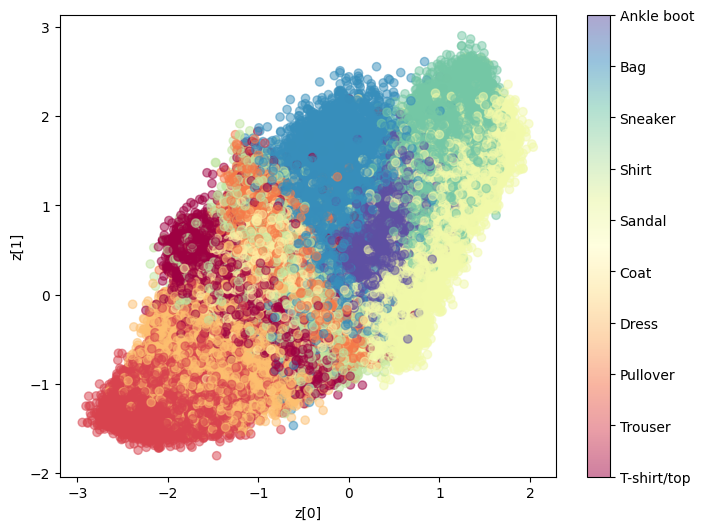

In [ ]:
plot_label_clusters(investigating_model, X_train ,y_train)